In [276]:
from pmdarima import auto_arima
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn import metrics
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [277]:
NEW_STEPWISE = False

def mase(y_true, y_pred):

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    mae_model = np.mean(np.abs(y_true - y_pred))
    mae_naive = np.mean(np.abs(y_true[1:] - y_true[:-1]))
    
    return mae_model / mae_naive if mae_naive != 0 else float('inf')



def printRegressionMetrics(y_true, y_pred):
    
    MAPE = metrics.mean_absolute_percentage_error(y_true, y_pred)
    MSE = metrics.mean_squared_error(y_true, y_pred)
    R2 = metrics.r2_score(y_true, y_pred)
    MASE = mase(y_true, y_pred)
    
    print('MSE:')
    print(MSE)
    print('MAPE:')
    print(MAPE)
    print('MASE:')
    print(MASE)
    print('R2:')
    print(R2)

In [278]:
data = pd.read_csv("./Dataset/dataOld.csv")
data = data.head(1000)

In [279]:
data["timestamp"] = data["timestamp"] / 1000
data["timestamp"] = data['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
data.reset_index(drop=True, inplace=True)

In [280]:
if NEW_STEPWISE:
    stepwise_model = auto_arima(teste['price'], trace=True, suppress_warnings=True)
    stepwise_model.summary()

'''

Best model:  ARIMA(4,1,5)(0,0,0)[0]          
Total fit time: 1037.301 seconds

'''

'\n\nBest model:  ARIMA(4,1,5)(0,0,0)[0]          \nTotal fit time: 1037.301 seconds\n\n'

In [281]:
data = data[['timestamp','price']]

data = data.set_index('timestamp')

train,test = train_test_split(data, test_size=0.3, shuffle=False)
pred = []

for i in range(len(test)):
    model = sm.tsa.ARIMA(train, order=(4,1,5))
    model_fit = model.fit()
    
    pred.append(model_fit.forecast(steps=1)[0])
    train = data[:train.shape[0] + i + 1]
    
printRegressionMetrics(test['price'], pred)

/home/mickael/.pyenv/versions/3.11.9/envs/dnnDef/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:543: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _index = np.asarray(index)


ValueError: Non-date index index provided to `dates` argument.

In [ ]:
len(pred)

24

In [ ]:
df_forecast = pd.DataFrame()
df_forecast['y_hat'] = np.hstack((train.to_numpy().flatten(), pred))
df_forecast['y_true'] = np.hstack((train.to_numpy().flatten(), test.to_numpy().flatten()))

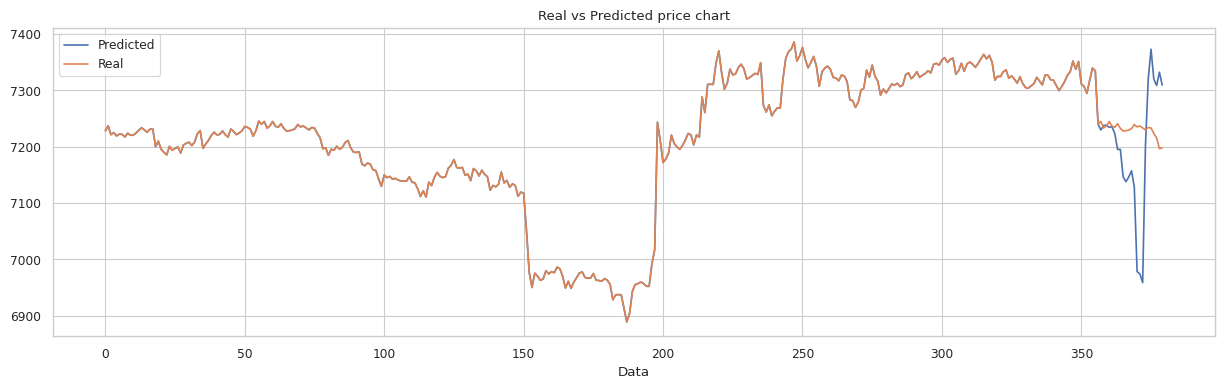

In [ ]:
sns.set_theme(rc={'figure.figsize':(15, 4)})
sns.set_style('whitegrid')
sns.set_context('paper')

ax = df_forecast.plot(x_compat=True, style='-')
ax.set_xlabel("Data")
ax.legend(["Predicted", "Real"])
ax.set_title("Real vs Predicted price chart")

plt.grid(True)
